In [2]:
!nvidia-smi

Fri Dec 12 03:44:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   29C    P0             51W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 셀 1: LlamaGen 클론
!git clone https://github.com/FoundationVision/LlamaGen.git

# 셀 2: 필요한 패키지 설치
!pip install omegaconf einops

# 셀 3: pretrained 다운로드
!mkdir -p /content/LlamaGen/pretrained_models
!wget -O /content/LlamaGen/pretrained_models/vq_ds16_c2i.pt \
    "https://huggingface.co/FoundationVision/LlamaGen/resolve/main/vq_ds16_c2i.pt"

# 셀 4: path 추가 (pip install 대신)
import sys
sys.path.append('/content/LlamaGen')

# 이제 import 가능
from tokenizer.tokenizer_image.vq_model import VQ_models
from tokenizer.tokenizer_image.discriminator_patchgan import NLayerDiscriminator
from tokenizer.tokenizer_image.lpips import LPIPS

Cloning into 'LlamaGen'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 191 (delta 59), reused 38 (delta 38), pack-reused 97 (from 1)
Receiving objects: 100% (191/191), 5.49 MiB | 35.34 MiB/s, done.
Resolving deltas: 100% (75/75), done.
--2025-12-12 03:44:45--  https://huggingface.co/FoundationVision/LlamaGen/resolve/main/vq_ds16_c2i.pt
Resolving huggingface.co (huggingface.co)... 18.239.50.16, 18.239.50.103, 18.239.50.80, ...
Connecting to huggingface.co (huggingface.co)|18.239.50.16|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cas-bridge.xethub.hf.co/xet-bridge-us/665e80456007027038347b8f/c2b95be6e19948ba724267d5ead95d7746e7aa62a17bca9fb22e5b7b96e98afa?X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Content-Sha256=UNSIGNED-PAYLOAD&X-Amz-Credential=cas%2F20251212%2Fus-east-1%2Fs3%2Faws4_request&X-Amz-Date=20251212T034445Z&X-Amz-Expires=3600&X-Amz-Sig

In [5]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np

-----------------------------------------------------------------------------
전처리 파이프라인 설명:

NEU-DET 이미지: 200x200 픽셀, 흑백(1채널)

VQGAN 입력: 256x256 픽셀, 컬러(3채널), 값 범위 [-1, 1]

그래서 다음 변환이 필요:
1. 200x200 → 256x256 크기 변경
2. 흑백 → RGB (채널 3개로 복제)
3. 픽셀값 [0, 255] → [0, 1] → [-1, 1]
-----------------------------------------------------------------------------


In [6]:
# T.Compose: 여러 변환을 순서대로 적용
transform = T.Compose([
    # 1단계: 크기 변경
    # 200x200 → 256x256
    T.Resize((256, 256)),

    # 2단계: 흑백 → RGB
    # num_output_channels=3: 같은 값을 3번 복제
    T.Grayscale(num_output_channels=3),

    # 3단계: PIL 이미지 → PyTorch 텐서
    # [0, 255] 정수 → [0, 1] 실수로 변환됨
    T.ToTensor(),

    # 4단계: 정규화
    # [0, 1] → [-1, 1] 범위로 변환
    # 공식: (값 - 0.5) / 0.5
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [7]:
def denormalize(tensor):
    """
    텐서를 다시 이미지로 바꾸기 위한 역변환 함수
    [-1, 1] → [0, 1] → numpy 배열

    Args:
        tensor: 정규화된 PyTorch 텐서

    Returns:
        numpy 배열 (이미지로 표시 가능)
    """
    # 원본 텐서를 수정하지 않도록 복사본 생성
    tensor = tensor.clone()

    # [-1, 1] → [0, 1]
    # 공식: 값 * 0.5 + 0.5
    tensor = tensor * 0.5 + 0.5

    # 값을 0~1 범위로 제한 (혹시 모를 오류 방지)
    tensor = tensor.clamp(0, 1)

    # 배치 차원이 있으면 제거
    # [1, 3, 256, 256] → [3, 256, 256]
    if tensor.dim() == 4:
        tensor = tensor[0]

    # PyTorch: [채널, 높이, 너비] → numpy: [높이, 너비, 채널]
    # matplotlib은 [높이, 너비, 채널] 형태를 기대함
    return tensor.permute(1, 2, 0).cpu().numpy()

In [8]:
import os

merged_path = "/content/drive/MyDrive/metal-defect/data/merged_dataset_200x200"
# 테스트용 이미지 경로 찾기
test_image_paths = os.path.join(merged_path, "crazing")

# 폴더 안의 이미지 목록
images = os.listdir(test_image_paths)

if images:
    # 첫 번째 이미지로 테스트
    sample_path = os.path.join(test_image_paths,images[0])

    # 이미지 열기
    sample_img = Image.open(sample_path)

    # 전처리 적용
    # unsqueeze(0): 배치 차원 추가 [3, 256, 256] → [1, 3, 256, 256]
    sample_tensor = transform(sample_img).unsqueeze(0)

    # 결과 확인
    print("=== 전처리 테스트 ===")
    print(f"원본 이미지: {sample_img.size}, 모드={sample_img.mode}")
    print(f"변환 후 텐서: {sample_tensor.shape}")
    print(f"값 범위: [{sample_tensor.min():.2f}, {sample_tensor.max():.2f}]")
    print("\n✅ 전처리 함수 준비 완료!")
else:
    print("❌ 테스트할 이미지가 없습니다. 경로를 확인하세요.")

=== 전처리 테스트 ===
원본 이미지: (200, 200), 모드=RGB
변환 후 텐서: torch.Size([1, 3, 256, 256])
값 범위: [-0.52, 1.00]

✅ 전처리 함수 준비 완료!


In [13]:
# LlamaGen VQGAN 생성 (config 파일 필요 없음!)
model = VQ_models["VQ-16"](
    codebook_size=16384,
    codebook_embed_dim=8,      # 핵심! taming은 256
    commit_loss_beta=0.25,
)

# pretrained 로드
ckpt = torch.load("/content/LlamaGen/pretrained_models/vq_ds16_c2i.pt", map_location="cpu")
if "model" in ckpt:
    model.load_state_dict(ckpt["model"])
elif "ema" in ckpt:
    model.load_state_dict(ckpt["ema"])
else:
    model.load_state_dict(ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
# 파라미터 수 계산
# p.numel(): 각 파라미터의 원소 개수
total_params = sum(p.numel() for p in model.parameters())

In [15]:
print(f"\n✅ VQGAN 모델 로드 완료!")
print(f"장치: {device}")
print(f"파라미터 수: {total_params:,}개")


✅ VQGAN 모델 로드 완료!
장치: cuda
파라미터 수: 71,883,403개


In [16]:
import matplotlib.pyplot as plt

In [17]:
# 테스트용 이미지 경로 찾기
test_image_paths = os.path.join(merged_path, "scratches")
images = os.listdir(test_image_paths)
test_path = os.path.join(test_image_paths,images[0])

test_img = Image.open(test_path)

In [18]:
# 전처리: PIL 이미지 → 텐서
# .unsqueeze(0): 배치 차원 추가 [3,256,256] → [1,3,256,256]
# .to(device): GPU로 이동
x = transform(test_img).unsqueeze(0).to(device)

print(f"입력 텐서 shape: {x.shape}")

입력 텐서 shape: torch.Size([1, 3, 256, 256])


-----------------------------------------------------------------------------
인코딩 → 디코딩
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------

In [19]:
# torch.no_grad(): 기울기 계산 안 함 (추론할 때 메모리 절약)
with torch.no_grad():
    # 1. 인코딩: 이미지 → 잠재 벡터 (latent)
    # model.encode()는 (z, emb_loss, info) 튜플 반환
    z, _, _ = model.encode(x)
    print(f"Latent shape: {z.shape}")  # [1, 256, 16, 16] 예상

    # 2. 양자화: 연속적인 latent → 이산적인 코드북 인덱스
    # 코드북: 16384개의 패턴 사전
    z_q, _, _ = model.quantize(z)
    print(f"Quantized shape: {z_q.shape}")

    # 3. 디코딩: 양자화된 latent → 이미지
    x_rec = model.decode(z_q)
    print(f"재구성 이미지 shape: {x_rec.shape}")

Latent shape: torch.Size([1, 8, 16, 16])
Quantized shape: torch.Size([1, 8, 16, 16])
재구성 이미지 shape: torch.Size([1, 3, 256, 256])


-----------------------------------------------------------------------------
시각화
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------

/tmp/ipython-input-2659401397.py:19: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2659401397.py:19: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2659401397.py:19: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2659401397.py:19: UserWarning: Glyph 52376 (\N{HANGUL SYLLABLE CEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2659401397.py:19: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2659401397.py:19: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2659401397.py:19: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

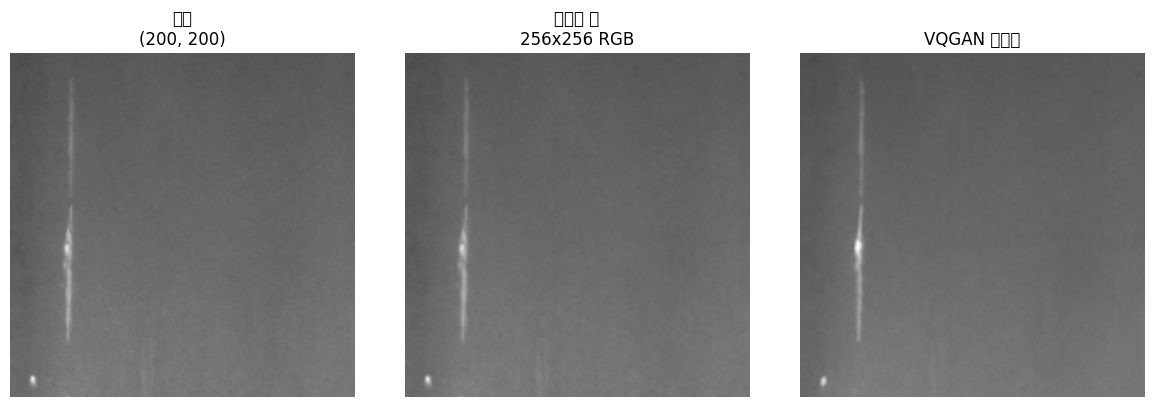

In [20]:
# 1행 3열 그래프
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 원본 이미지 (PIL)
axes[0].imshow(test_img, cmap='gray')
axes[0].set_title(f"원본\n{test_img.size}")
axes[0].axis('off')

# 전처리된 이미지 (텐서 → numpy)
axes[1].imshow(denormalize(x))
axes[1].set_title(f"전처리 후\n256x256 RGB")
axes[1].axis('off')

# 재구성 이미지
axes[2].imshow(denormalize(x_rec))
axes[2].set_title("VQGAN 재구성")
axes[2].axis('off')

plt.tight_layout()

In [21]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# 텐서 → numpy 변환 (0~1 범위)
img_original = denormalize(x)  # 전처리된 이미지
img_reconstructed = denormalize(x_rec)  # 재구성 이미지

# numpy array로 변환
if not isinstance(img_original, np.ndarray):
    img_original = np.array(img_original)
    img_reconstructed = np.array(img_reconstructed)

# 1. MSE (Mean Squared Error) - 낮을수록 좋음
mse = np.mean((img_original - img_reconstructed) ** 2)

# 2. PSNR (Peak Signal-to-Noise Ratio) - 높을수록 좋음 (보통 30+ 좋음)
psnr_value = psnr(img_original, img_reconstructed, data_range=1.0)

# 3. SSIM (Structural Similarity) - 1에 가까울수록 좋음
ssim_value = ssim(img_original, img_reconstructed, channel_axis=2, data_range=1.0)

print("=== 이미지 품질 비교 ===")
print(f"MSE:  {mse:.6f}  (낮을수록 좋음)")
print(f"PSNR: {psnr_value:.2f} dB  (30+ 좋음, 40+ 매우좋음)")
print(f"SSIM: {ssim_value:.4f}  (1에 가까울수록 좋음)")

=== 이미지 품질 비교 ===
MSE:  0.000138  (낮을수록 좋음)
PSNR: 38.62 dB  (30+ 좋음, 40+ 매우좋음)
SSIM: 0.9481  (1에 가까울수록 좋음)


=============================================================================
PyTorch Dataset 클래스 정의 (Fine-tuning용)
=============================================================================
=============================================================================

In [22]:
# Dataset: 데이터를 불러오는 방법을 정의
# DataLoader: 배치 단위로 데이터를 공급
from torch.utils.data import Dataset, DataLoader

class NEUDataset(Dataset):
    """
    NEU-DET 데이터셋을 PyTorch가 이해하는 형태로 감싸는 클래스

    Dataset을 상속받으면 __len__과 __getitem__을 구현해야 함
    """

    def __init__(self, root_dir,transform=None):
        """
        초기화 함수 (객체 생성 시 호출)

        Args:
            root_dir: merged 폴더 경로
            transform: 이미지 전처리 함수
        """
        # 이미지 경로 저장할 리스트
        self.image_paths = []
        # 라벨(클래스 번호) 저장할 리스트
        self.labels = []
        # 클래스 이름 저장할 리스트
        self.class_names = []

        # 실제 이미지 폴더 경로 구성
        images_dir = os.path.join(root_dir)

        if not os.path.exists(images_dir):
            raise ValueError(f"경로가 없습니다: {images_dir}")

        # root_dir 안의 모든 폴더 탐색
        # sorted(): 알파벳 순 정렬 (일관된 순서 보장)
        # enumerate(): 인덱스와 값을 동시에 반환
        for class_idx, class_name in enumerate(sorted(os.listdir(images_dir))):
            # 전체 경로 만들기
            class_dir = os.path.join(images_dir, class_name)

            # 폴더인지 확인 (파일 제외)
            if os.path.isdir(class_dir):
                # 클래스 이름 저장
                self.class_names.append(class_name)

                # 해당 폴더의 모든 이미지 파일
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    # 경로와 라벨 저장
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)

        # 전처리 함수 저장
        # transform이 None이면 기본 전처리 사용
        if transform is None:
            self.transform = T.Compose([
                T.Resize((256, 256)),
                T.Grayscale(num_output_channels=3),
                T.ToTensor(),
                T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])
        else:
            self.transform = transform

        # 데이터셋 정보 출력
        print(f"클래스: {self.class_names}")
        print(f"총 이미지: {len(self.image_paths)}장")

    def __len__(self):
        """
        데이터셋 크기 반환 (len(dataset)하면 호출됨)
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        인덱스로 데이터 하나 가져오기 (dataset[0]하면 호출됨)

        Args:
            idx: 가져올 데이터의 인덱스

        Returns:
            (이미지 텐서, 라벨) 튜플
        """
        # 이미지 열기
        img = Image.open(self.image_paths[idx])

        # 전처리 적용
        img = self.transform(img)

        # 라벨
        label = self.labels[idx]

        return img, label

 -----------------------------------------------------------------------------
데이터셋 & 데이터로더 생성
 -----------------------------------------------------------------------------
 -----------------------------------------------------------------------------


In [23]:
# train 데이터셋
dataset = NEUDataset(root_dir=merged_path)

클래스: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']
총 이미지: 2659장


In [24]:
# 배치 사이즈: 한 번에 처리할 이미지 수
# GPU 메모리에 따라 조절 (8~16 권장)
# 메모리 에러 나면 줄이기
batch_size = 8

# DataLoader: 데이터를 배치 단위로 공급
# shuffle=True: 매 에폭마다 순서 섞기
# num_workers=2: 데이터 로딩에 2개 프로세스 사용
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

# 테스트: 첫 번째 배치 가져오기
# next(iter()): 반복자에서 첫 번째 요소 가져오기
test_batch, test_labels = next(iter(dataloader))

print(f"\n배치 shape: {test_batch.shape}")  # [8, 3, 256, 256]
print(f"라벨: {test_labels}")


배치 shape: torch.Size([8, 3, 256, 256])
라벨: tensor([2, 5, 5, 5, 1, 5, 2, 2])


=============================================================================
Fine-tuning 설정
=============================================================================
=============================================================================

In [25]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# -----------------------------------------------------------------------------
# 하이퍼파라미터 설정
# -----------------------------------------------------------------------------

# Learning Rate (학습률)
# 너무 크면: 학습이 불안정, 기존 지식 손실
# 너무 작으면: 학습이 너무 느림
# 사전학습 모델 fine-tuning 시에는 작은 값 사용!
learning_rate = 1e-5  # 0.00001

# 에폭 수: 전체 데이터를 몇 번 반복할지
# NEU-DET 1800장, 배치 8개 → 1 에폭 = 225 스텝
# 30 에폭 = 약 6,750 스텝
num_epochs = 30

# 몇 에폭마다 모델 저장할지
save_every = 1

In [27]:
model.train()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

mse_loss = nn.MSELoss()

# 저장 경로
save_dir = "/content/drive/MyDrive/metal-defect/LlamaGen/checkpoints"
os.makedirs(save_dir, exist_ok=True)

# 설정 확인
print("=== Fine-tuning 설정 ===")
print(f"Learning Rate: {learning_rate}")
print(f"Epochs: {num_epochs}")
print(f"Batch Size: {batch_size}")
print(f"총 스텝 수: 약 {num_epochs * len(dataloader):,}")
print(f"저장 경로: {save_dir}")

=== Fine-tuning 설정 ===
Learning Rate: 1e-05
Epochs: 30
Batch Size: 8
총 스텝 수: 약 9,990
저장 경로: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints


=============================================================================
Fine-tuning 수행
=============================================================================
=============================================================================

In [28]:
# =============================================================================
# VQGAN Fine-tuning (LlamaGen 버전)
# =============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

# LlamaGen 모듈 불러오기
import sys
sys.path.append('/content/LlamaGen')

from omegaconf import OmegaConf
from tokenizer.tokenizer_image.vq_model import VQ_models  # [변경] VQModel → VQ_models
from tokenizer.tokenizer_image.discriminator_patchgan import NLayerDiscriminator
from tokenizer.tokenizer_image.lpips import LPIPS

# =============================================================================
# 1. adopt_weight 함수
# =============================================================================
# global_step이 threshold보다 작으면 weight를 value(기본값 0)로 설정합니다.
# 즉, 학습 초반에는 GAN loss를 0으로 만들어서 reconstruction만 학습하고,
# threshold 스텝 이후부터 GAN loss를 활성화합니다.

def adopt_weight(weight, global_step, threshold=0, value=0.):
    if global_step < threshold:
        weight = value
    return weight


# =============================================================================
# 2. Hinge Loss 함수들
# =============================================================================
# Discriminator용과 Generator용이 따로 있는 게 아니라,
# Discriminator loss만 함수로 정의하고, Generator loss는 forward에서 직접 계산합니다.

def hinge_d_loss(logits_real, logits_fake):
    """
    Discriminator용 Hinge Loss
    - logits_real: 진짜 이미지에 대한 discriminator 출력
    - logits_fake: 가짜(재구성) 이미지에 대한 discriminator 출력

    진짜는 1보다 크게, 가짜는 -1보다 작게 만들려고 합니다.
    relu(1 - real): real이 1보다 크면 0, 작으면 페널티
    relu(1 + fake): fake가 -1보다 작으면 0, 크면 페널티
    """
    loss_real = torch.mean(F.relu(1. - logits_real))
    loss_fake = torch.mean(F.relu(1. + logits_fake))
    d_loss = 0.5 * (loss_real + loss_fake)
    return d_loss


# =============================================================================
# 3. Adaptive Weight 계산 함수
# =============================================================================
# 이 함수가 코드의 핵심입니다.
# reconstruction loss와 GAN loss의 gradient 크기를 비교해서
# 두 loss가 비슷한 영향력을 갖도록 가중치를 자동 조절합니다.

def calculate_adaptive_weight(nll_loss, g_loss, last_layer, disc_weight=1.0):
    """
    Adaptive weight 계산

    Parameters:
    - nll_loss: reconstruction loss (L1 + perceptual)
    - g_loss: generator의 GAN loss
    - last_layer: decoder의 마지막 레이어 weight (gradient 계산 기준점)
    - disc_weight: 기본 discriminator weight (config에서 설정, 보통 0.8)

    Returns:
    - d_weight: GAN loss에 곱해줄 adaptive weight
    """
    # 각 loss가 last_layer에 미치는 gradient를 계산합니다.
    # retain_graph=True: 이후에도 backward를 또 할 수 있도록 그래프를 유지합니다.
    nll_grads = torch.autograd.grad(nll_loss, last_layer, retain_graph=True)[0]
    g_grads = torch.autograd.grad(g_loss, last_layer, retain_graph=True)[0]

    # gradient의 L2 norm(크기)을 계산해서 비율을 구합니다.
    # nll_grads가 크고 g_grads가 작으면 d_weight가 커져서 GAN loss 영향력 증가
    # nll_grads가 작고 g_grads가 크면 d_weight가 작아져서 GAN loss 영향력 감소
    # 1e-4는 division by zero 방지용 epsilon입니다.
    d_weight = torch.norm(nll_grads) / (torch.norm(g_grads) + 1e-4)

    # 극단적인 값 방지: 0 ~ 10000 사이로 clamp
    d_weight = torch.clamp(d_weight, 0.0, 1e4).detach()

    # config에서 설정한 disc_weight를 곱해줍니다.
    d_weight = d_weight * disc_weight

    d_weight = torch.clamp(d_weight, min=0.1)

    return d_weight


# =============================================================================
# 4. 모델 및 컴포넌트 로드
# =============================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt_dir = "/content/drive/MyDrive/metal-defect/LlamaGen/checkpoints"
save_dir = f"{ckpt_dir}"                       # 저장 디렉토리

model = VQ_models["VQ-16"](
    codebook_size=16384,
    codebook_embed_dim=8,      # [핵심] taming은 256, LlamaGen은 8
    commit_loss_beta=0.25,
    entropy_loss_ratio=0.0,
    codebook_l2_norm=True,
)

# 전체 체크포인트 로드
ckpt_path = "/content/LlamaGen/pretrained_models/vq_ds16_c2i.pt"
ckpt = torch.load(ckpt_path, map_location="cpu", weights_only=False)

# LlamaGen 체크포인트 구조: {"model": ..., "ema": ..., ...}
if "model" in ckpt:
    model.load_state_dict(ckpt["model"])
    print("✅ VQModel 로드 완료 (model 키)")
elif "ema" in ckpt:
    model.load_state_dict(ckpt["ema"])
    print("✅ VQModel 로드 완료 (ema 키)")
else:
    # 혹시 state_dict가 직접 저장된 경우
    model.load_state_dict(ckpt)
    print("✅ VQModel 로드 완료 (직접)")

model = model.to(device)

# -----------------------------------------------------------------------------
# Discriminator 로드
# -----------------------------------------------------------------------------
discriminator = NLayerDiscriminator(
    input_nc=3,      # RGB 입력
    n_layers=2,      # 레이어 수 (원본 config 기준)
    ndf=64           # 기본 필터 수
)

discriminator = discriminator.to(device)

# -----------------------------------------------------------------------------
# Perceptual Loss (LPIPS) 로드
# -----------------------------------------------------------------------------
perceptual_loss = LPIPS().eval()
perceptual_loss = perceptual_loss.to(device)

# LPIPS는 고정 (학습하지 않음)
for param in perceptual_loss.parameters():
    param.requires_grad = False

print("✅ Perceptual Loss (LPIPS) 로드 완료")


# =============================================================================
# 5. 하이퍼파라미터 설정 (원본 config 기준)
# =============================================================================

# 학습 설정
num_epochs = 50
save_every = 5

# Loss 가중치들 (원본 config 기준)
codebook_weight = 1.0       # codebook loss 가중치
pixel_weight = 1.0          # L1 reconstruction loss 가중치
perceptual_weight = 1.0     # perceptual loss 가중치
disc_weight = 0.8           # discriminator weight (adaptive weight 계산에 사용)
disc_factor = 1.0           # GAN loss 전체에 곱해지는 factor
learning_rate = 4.5e-6

# Discriminator 시작 스텝
# 원본 config들 보면 10000 ~ 250001까지 다양함
# fine-tuning이니까 좀 더 빠르게 시작해도 됨
disc_start = 1000

print(f"\n=== 하이퍼파라미터 ===")
print(f"Learning Rate: {learning_rate}")
print(f"Codebook Weight: {codebook_weight}")
print(f"Perceptual Weight: {perceptual_weight}")
print(f"Disc Weight: {disc_weight}")
print(f"Disc Start: {disc_start} steps")


# =============================================================================
# 6. Optimizer 설정
# =============================================================================

# 학습 파라미터 수 확인
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\n학습 파라미터: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.1f}%)")

# Generator (VQModel) optimizer
# 원본은 Adam with betas=(0.5, 0.9)
optimizer_g = optim.Adam([
    {'params': model.encoder.parameters(), 'lr': 1e-7},
    {'params': model.quant_conv.parameters(), 'lr': 1e-7},
    {'params': model.quantize.parameters(), 'lr': 4.5e-6},
    {'params': model.post_quant_conv.parameters(), 'lr': 4.5e-6},
    {'params': model.decoder.parameters(), 'lr': 4.5e-6},
], betas=(0.5, 0.9))

# Discriminator optimizer
optimizer_d = optim.Adam(
    discriminator.parameters(),
    lr=1.8e-5,
    betas=(0.5, 0.9)
)


# =============================================================================
# 7. Fine-tuning 메인 루프
# =============================================================================

# 학습 기록용
train_logs = []
global_step = 0

print("\n" + "=" * 70)
print("VQGAN Fine-tuning 시작 (LlamaGen)")
print("=" * 70 + "\n")

for epoch in range(num_epochs):
    model.train()
    discriminator.train()

    epoch_logs = {
        'total_loss': 0, 'nll_loss': 0, 'codebook_loss': 0,
        'g_loss': 0, 'd_loss': 0, 'd_weight': 0
    }

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (images, _) in enumerate(pbar):
        images = images.to(device)
        global_step += 1

        # =================================================================
        # Forward Pass: Encode -> Quantize -> Decode
        # =================================================================

        # encode: 이미지를 latent space로 인코딩
        z = model.encoder(images)
        z = model.quant_conv(z)

        # quantize: latent를 codebook의 가장 가까운 벡터로 양자화
        # 반환값: (양자화된 z, loss, (perplexity, min_encodings, min_encoding_indices))
        # 여기서 두 번째 반환값이 codebook_loss입니다!
        z_q, codebook_loss_tuple, indices = model.quantize(z)

        # tuple 풀기
        vq_loss, commit_loss, entropy_loss, codebook_usage = codebook_loss_tuple
        # 합쳐서 total codebook loss 계산
        codebook_loss = vq_loss + commit_loss + entropy_loss

        z_q = model.post_quant_conv(z_q)
        reconstructions = model.decoder(z_q)

        # =================================================================
        # Generator (VQModel) 업데이트 - optimizer_idx = 0
        # =================================================================

        # ----- nll_loss 계산 (L1 + Perceptual) -----
        # 원본 코드: rec_loss = L1 + perceptual_weight * p_loss
        # 그 다음 nll_loss = mean(rec_loss)

        # L1 reconstruction loss (픽셀 단위 절대값 차이)
        rec_loss = torch.abs(images.contiguous() - reconstructions.contiguous())

        # Perceptual loss 추가
        if perceptual_weight > 0:
            p_loss = perceptual_loss(images.contiguous(), reconstructions.contiguous())
            rec_loss = rec_loss + perceptual_weight * p_loss
        else:
            p_loss = torch.tensor([0.0]).to(device)

        # 평균 내서 nll_loss 완성
        nll_loss = torch.mean(rec_loss)

        # ----- GAN loss (Generator 입장) -----
        # Generator는 Discriminator를 속이고 싶음
        # Discriminator가 fake를 real로 판단하면 logits_fake가 높아짐
        # Generator loss = -mean(logits_fake): fake의 점수가 높을수록 loss 감소

        logits_fake = discriminator(reconstructions.contiguous())
        g_loss = -torch.mean(logits_fake)

        # ----- Adaptive Weight 계산 -----
        # disc_start 이전에는 d_weight 계산을 건너뜁니다.
        # 왜냐하면 아직 GAN loss를 쓰지 않을 거니까요.

        # disc_factor: disc_start 이전이면 0, 이후면 원래 값
        current_disc_factor = adopt_weight(disc_factor, global_step, threshold=disc_start)

        if current_disc_factor > 0:
            # Adaptive weight 계산
            # last_layer: decoder의 마지막 conv layer의 weight
            # 이 레이어 기준으로 각 loss의 gradient 크기를 비교합니다.
            try:
                d_weight = calculate_adaptive_weight(
                    nll_loss, g_loss,
                    last_layer=model.decoder.conv_out.weight,
                    disc_weight=disc_weight
                )
            except RuntimeError:
                # validation 등에서 gradient 계산 불가능한 경우
                d_weight = torch.tensor(0.0).to(device)
        else:
            d_weight = torch.tensor(0.0).to(device)

        # ----- Total Generator Loss -----
        # 원본 공식: loss = nll_loss + d_weight * disc_factor * g_loss + codebook_weight * codebook_loss
        loss_g = (nll_loss +
                  d_weight * current_disc_factor * g_loss +
                  codebook_weight * codebook_loss)

        # Generator 업데이트
        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # =================================================================
        # Discriminator 업데이트 - optimizer_idx = 1
        # =================================================================

        if current_disc_factor > 0:
            # Real과 Fake 이미지에 대한 Discriminator 출력
            # .detach(): Generator로 gradient가 흐르지 않도록 끊어줍니다.
            # 여기서는 Discriminator만 학습하니까요.
            logits_real = discriminator(images.contiguous().detach())
            logits_fake = discriminator(reconstructions.contiguous().detach())

            # Discriminator loss: hinge loss 사용
            d_loss = current_disc_factor * hinge_d_loss(logits_real, logits_fake)

            # Discriminator 업데이트
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()
        else:
            d_loss = torch.tensor(0.0).to(device)

        # =================================================================
        # 로깅
        # =================================================================

        epoch_logs['total_loss'] += loss_g.item()
        epoch_logs['nll_loss'] += nll_loss.item()
        epoch_logs['codebook_loss'] += codebook_loss.item()
        epoch_logs['g_loss'] += g_loss.item()
        epoch_logs['d_loss'] += d_loss.item()
        epoch_logs['d_weight'] += d_weight.item() if torch.is_tensor(d_weight) else d_weight

        # tqdm에 현재 상태 표시
        pbar.set_postfix({
            'loss': f'{loss_g.item():.4f}',
            'nll': f'{nll_loss.item():.4f}',
            'cb': f'{codebook_loss.item():.4f}',
            'd_w': f'{d_weight.item() if torch.is_tensor(d_weight) else d_weight:.2f}',
            'D': f'{d_loss.item():.4f}',
            'usage': f'{codebook_usage:.1%}'
        })

    # 에폭 평균 계산
    n_batches = len(dataloader)
    for key in epoch_logs:
        epoch_logs[key] /= n_batches

    train_logs.append(epoch_logs)

    print(f"\nEpoch {epoch+1} 완료")
    print(f"  Total Loss: {epoch_logs['total_loss']:.4f}")
    print(f"  NLL Loss: {epoch_logs['nll_loss']:.4f}")
    print(f"  Codebook Loss: {epoch_logs['codebook_loss']:.4f}")
    print(f"  G Loss: {epoch_logs['g_loss']:.4f}")
    print(f"  D Loss: {epoch_logs['d_loss']:.4f}")
    print(f"  Avg D Weight: {epoch_logs['d_weight']:.2f}")

    # 주기적 저장
    if (epoch + 1) % save_every == 0:
        save_path = f"{save_dir}/vqgan_finetune_up_epoch{epoch+1}.pt"
        torch.save({
            'epoch': epoch + 1,
            'global_step': global_step,
            'vqmodel': model.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, save_path)
        print(f"  💾 체크포인트 저장: {save_path}")

print("\n" + "=" * 70)
print("✅ Fine-tuning 완료!")
print("=" * 70)

✅ VQModel 로드 완료 (model 키)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 246MB/s]


loaded pretrained LPIPS loss from /content/LlamaGen/tokenizer/tokenizer_image/cache/vgg.pth
✅ Perceptual Loss (LPIPS) 로드 완료

=== 하이퍼파라미터 ===
Learning Rate: 4.5e-06
Codebook Weight: 1.0
Perceptual Weight: 1.0
Disc Weight: 0.8
Disc Start: 1000 steps

학습 파라미터: 71,883,403 / 71,883,403 (100.0%)

VQGAN Fine-tuning 시작 (LlamaGen)



Epoch 1/50: 100%|██████████| 333/333 [08:59<00:00,  1.62s/it, loss=0.2518, nll=0.2389, cb=0.0129, d_w=0.00, D=0.0000, usage=72.9%]



Epoch 1 완료
  Total Loss: 0.2919
  NLL Loss: 0.2789
  Codebook Loss: 0.0130
  G Loss: 0.1628
  D Loss: 0.0000
  Avg D Weight: 0.00


Epoch 2/50: 100%|██████████| 333/333 [01:33<00:00,  3.58it/s, loss=0.2447, nll=0.2316, cb=0.0131, d_w=0.00, D=0.0000, usage=74.4%]



Epoch 2 완료
  Total Loss: 0.2869
  NLL Loss: 0.2739
  Codebook Loss: 0.0130
  G Loss: 0.1626
  D Loss: 0.0000
  Avg D Weight: 0.00


Epoch 3/50: 100%|██████████| 333/333 [01:33<00:00,  3.56it/s, loss=0.3817, nll=0.3683, cb=0.0134, d_w=0.00, D=0.0000, usage=74.1%]



Epoch 3 완료
  Total Loss: 0.2847
  NLL Loss: 0.2717
  Codebook Loss: 0.0130
  G Loss: 0.1612
  D Loss: 0.0000
  Avg D Weight: 0.00


Epoch 4/50: 100%|██████████| 333/333 [01:40<00:00,  3.31it/s, loss=0.3916, nll=0.3813, cb=0.0133, d_w=0.25, D=0.9962, usage=73.5%]



Epoch 4 완료
  Total Loss: 0.3713
  NLL Loss: 0.2747
  Codebook Loss: 0.0130
  G Loss: 0.1315
  D Loss: 0.9989
  Avg D Weight: 0.63


Epoch 5/50: 100%|██████████| 333/333 [01:40<00:00,  3.31it/s, loss=0.3601, nll=0.3551, cb=0.0130, d_w=0.50, D=0.9942, usage=73.7%]



Epoch 5 완료
  Total Loss: 0.3300
  NLL Loss: 0.2750
  Codebook Loss: 0.0130
  G Loss: 0.1239
  D Loss: 0.9942
  Avg D Weight: 0.34
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/vqgan_finetune_up_epoch5.pt


Epoch 6/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.4085, nll=0.3269, cb=0.0130, d_w=0.64, D=0.9927, usage=74.5%]



Epoch 6 완료
  Total Loss: 0.3229
  NLL Loss: 0.2747
  Codebook Loss: 0.0130
  G Loss: 0.1193
  D Loss: 0.9937
  Avg D Weight: 0.30


Epoch 7/50: 100%|██████████| 333/333 [01:40<00:00,  3.31it/s, loss=0.3277, nll=0.2999, cb=0.0128, d_w=0.16, D=0.9904, usage=75.3%]



Epoch 7 완료
  Total Loss: 0.3270
  NLL Loss: 0.2740
  Codebook Loss: 0.0130
  G Loss: 0.1495
  D Loss: 0.9919
  Avg D Weight: 0.26


Epoch 8/50: 100%|██████████| 333/333 [01:41<00:00,  3.30it/s, loss=0.3118, nll=0.2700, cb=0.0131, d_w=0.23, D=0.9808, usage=74.8%]



Epoch 8 완료
  Total Loss: 0.3102
  NLL Loss: 0.2727
  Codebook Loss: 0.0130
  G Loss: 0.1390
  D Loss: 0.9865
  Avg D Weight: 0.18


Epoch 9/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2735, nll=0.2428, cb=0.0129, d_w=0.10, D=0.9910, usage=75.0%]



Epoch 9 완료
  Total Loss: 0.3006
  NLL Loss: 0.2716
  Codebook Loss: 0.0130
  G Loss: 0.1436
  D Loss: 0.9783
  Avg D Weight: 0.11


Epoch 10/50: 100%|██████████| 333/333 [01:40<00:00,  3.31it/s, loss=0.2884, nll=0.2670, cb=0.0131, d_w=0.10, D=0.9928, usage=75.0%]



Epoch 10 완료
  Total Loss: 0.2975
  NLL Loss: 0.2710
  Codebook Loss: 0.0130
  G Loss: 0.1347
  D Loss: 0.9718
  Avg D Weight: 0.10
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/vqgan_finetune_up_epoch10.pt


Epoch 11/50: 100%|██████████| 333/333 [01:41<00:00,  3.27it/s, loss=0.2739, nll=0.1932, cb=0.0129, d_w=0.10, D=0.9809, usage=75.2%]



Epoch 11 완료
  Total Loss: 0.2937
  NLL Loss: 0.2703
  Codebook Loss: 0.0130
  G Loss: 0.1024
  D Loss: 0.9679
  Avg D Weight: 0.10


Epoch 12/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.3093, nll=0.2879, cb=0.0131, d_w=0.10, D=0.9415, usage=74.7%]



Epoch 12 완료
  Total Loss: 0.2905
  NLL Loss: 0.2702
  Codebook Loss: 0.0130
  G Loss: 0.0740
  D Loss: 0.9665
  Avg D Weight: 0.10


Epoch 13/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2847, nll=0.2682, cb=0.0132, d_w=0.10, D=0.9582, usage=75.1%]



Epoch 13 완료
  Total Loss: 0.2893
  NLL Loss: 0.2696
  Codebook Loss: 0.0130
  G Loss: 0.0673
  D Loss: 0.9643
  Avg D Weight: 0.10


Epoch 14/50: 100%|██████████| 333/333 [01:40<00:00,  3.31it/s, loss=0.2676, nll=0.2453, cb=0.0129, d_w=0.10, D=0.9650, usage=75.3%]



Epoch 14 완료
  Total Loss: 0.2872
  NLL Loss: 0.2692
  Codebook Loss: 0.0130
  G Loss: 0.0505
  D Loss: 0.9620
  Avg D Weight: 0.10


Epoch 15/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.3398, nll=0.3450, cb=0.0129, d_w=0.10, D=0.9857, usage=75.7%]



Epoch 15 완료
  Total Loss: 0.2846
  NLL Loss: 0.2690
  Codebook Loss: 0.0130
  G Loss: 0.0262
  D Loss: 0.9597
  Avg D Weight: 0.10
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/vqgan_finetune_up_epoch15.pt


Epoch 16/50: 100%|██████████| 333/333 [01:41<00:00,  3.29it/s, loss=0.3831, nll=0.4137, cb=0.0129, d_w=0.10, D=0.9782, usage=75.9%]



Epoch 16 완료
  Total Loss: 0.2843
  NLL Loss: 0.2687
  Codebook Loss: 0.0130
  G Loss: 0.0258
  D Loss: 0.9588
  Avg D Weight: 0.10


Epoch 17/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2871, nll=0.2983, cb=0.0129, d_w=0.10, D=0.9565, usage=76.1%]



Epoch 17 완료
  Total Loss: 0.2828
  NLL Loss: 0.2682
  Codebook Loss: 0.0130
  G Loss: 0.0163
  D Loss: 0.9555
  Avg D Weight: 0.10


Epoch 18/50: 100%|██████████| 333/333 [01:40<00:00,  3.31it/s, loss=0.3017, nll=0.2777, cb=0.0129, d_w=0.10, D=0.9597, usage=76.4%]



Epoch 18 완료
  Total Loss: 0.2825
  NLL Loss: 0.2678
  Codebook Loss: 0.0130
  G Loss: 0.0172
  D Loss: 0.9541
  Avg D Weight: 0.10


Epoch 19/50: 100%|██████████| 333/333 [01:40<00:00,  3.31it/s, loss=0.2593, nll=0.2274, cb=0.0129, d_w=0.10, D=0.9492, usage=75.8%]



Epoch 19 완료
  Total Loss: 0.2809
  NLL Loss: 0.2674
  Codebook Loss: 0.0129
  G Loss: 0.0057
  D Loss: 0.9538
  Avg D Weight: 0.10


Epoch 20/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2428, nll=0.2288, cb=0.0128, d_w=0.22, D=0.9590, usage=76.4%]



Epoch 20 완료
  Total Loss: 0.2819
  NLL Loss: 0.2671
  Codebook Loss: 0.0129
  G Loss: 0.0189
  D Loss: 0.9520
  Avg D Weight: 0.10
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/vqgan_finetune_up_epoch20.pt


Epoch 21/50: 100%|██████████| 333/333 [01:42<00:00,  3.26it/s, loss=0.2495, nll=0.2209, cb=0.0130, d_w=0.10, D=0.9894, usage=76.7%]



Epoch 21 완료
  Total Loss: 0.2808
  NLL Loss: 0.2667
  Codebook Loss: 0.0129
  G Loss: 0.0114
  D Loss: 0.9499
  Avg D Weight: 0.10


Epoch 22/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.3068, nll=0.3078, cb=0.0130, d_w=0.10, D=0.9319, usage=77.2%]



Epoch 22 완료
  Total Loss: 0.2792
  NLL Loss: 0.2666
  Codebook Loss: 0.0129
  G Loss: -0.0030
  D Loss: 0.9467
  Avg D Weight: 0.10


Epoch 23/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2600, nll=0.2188, cb=0.0127, d_w=0.10, D=0.9276, usage=76.5%]



Epoch 23 완료
  Total Loss: 0.2804
  NLL Loss: 0.2662
  Codebook Loss: 0.0129
  G Loss: 0.0126
  D Loss: 0.9477
  Avg D Weight: 0.10


Epoch 24/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2843, nll=0.2887, cb=0.0127, d_w=0.10, D=0.9484, usage=76.8%]



Epoch 24 완료
  Total Loss: 0.2782
  NLL Loss: 0.2661
  Codebook Loss: 0.0129
  G Loss: -0.0085
  D Loss: 0.9448
  Avg D Weight: 0.10


Epoch 25/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2710, nll=0.2382, cb=0.0130, d_w=0.10, D=0.8813, usage=76.4%]



Epoch 25 완료
  Total Loss: 0.2791
  NLL Loss: 0.2656
  Codebook Loss: 0.0129
  G Loss: 0.0048
  D Loss: 0.9426
  Avg D Weight: 0.10
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/vqgan_finetune_up_epoch25.pt


Epoch 26/50: 100%|██████████| 333/333 [01:42<00:00,  3.26it/s, loss=0.2679, nll=0.2981, cb=0.0129, d_w=0.10, D=0.9730, usage=77.3%]



Epoch 26 완료
  Total Loss: 0.2781
  NLL Loss: 0.2655
  Codebook Loss: 0.0129
  G Loss: -0.0033
  D Loss: 0.9404
  Avg D Weight: 0.10


Epoch 27/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2521, nll=0.2563, cb=0.0126, d_w=0.10, D=0.9644, usage=77.0%]



Epoch 27 완료
  Total Loss: 0.2776
  NLL Loss: 0.2653
  Codebook Loss: 0.0129
  G Loss: -0.0058
  D Loss: 0.9395
  Avg D Weight: 0.10


Epoch 28/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2337, nll=0.2260, cb=0.0131, d_w=0.10, D=0.9723, usage=77.6%]



Epoch 28 완료
  Total Loss: 0.2773
  NLL Loss: 0.2650
  Codebook Loss: 0.0129
  G Loss: -0.0061
  D Loss: 0.9386
  Avg D Weight: 0.10


Epoch 29/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.3387, nll=0.3257, cb=0.0132, d_w=0.10, D=0.9061, usage=77.5%]



Epoch 29 완료
  Total Loss: 0.2787
  NLL Loss: 0.2649
  Codebook Loss: 0.0129
  G Loss: 0.0092
  D Loss: 0.9373
  Avg D Weight: 0.10


Epoch 30/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2815, nll=0.2574, cb=0.0131, d_w=0.10, D=0.9410, usage=77.7%]



Epoch 30 완료
  Total Loss: 0.2776
  NLL Loss: 0.2646
  Codebook Loss: 0.0129
  G Loss: 0.0008
  D Loss: 0.9346
  Avg D Weight: 0.10
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/vqgan_finetune_up_epoch30.pt


Epoch 31/50: 100%|██████████| 333/333 [01:41<00:00,  3.28it/s, loss=0.2665, nll=0.2791, cb=0.0130, d_w=0.10, D=0.9570, usage=77.8%]



Epoch 31 완료
  Total Loss: 0.2785
  NLL Loss: 0.2643
  Codebook Loss: 0.0129
  G Loss: 0.0124
  D Loss: 0.9332
  Avg D Weight: 0.10


Epoch 32/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.3233, nll=0.2272, cb=0.0130, d_w=0.10, D=0.8698, usage=77.7%]



Epoch 32 완료
  Total Loss: 0.2783
  NLL Loss: 0.2639
  Codebook Loss: 0.0129
  G Loss: 0.0150
  D Loss: 0.9270
  Avg D Weight: 0.10


Epoch 33/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.3105, nll=0.3166, cb=0.0128, d_w=0.10, D=0.9890, usage=78.3%]



Epoch 33 완료
  Total Loss: 0.2785
  NLL Loss: 0.2640
  Codebook Loss: 0.0129
  G Loss: 0.0155
  D Loss: 0.9269
  Avg D Weight: 0.10


Epoch 34/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2126, nll=0.1866, cb=0.0128, d_w=0.10, D=1.0591, usage=78.1%]



Epoch 34 완료
  Total Loss: 0.2768
  NLL Loss: 0.2634
  Codebook Loss: 0.0129
  G Loss: 0.0049
  D Loss: 0.9269
  Avg D Weight: 0.10


Epoch 35/50: 100%|██████████| 333/333 [01:41<00:00,  3.30it/s, loss=0.2298, nll=0.2343, cb=0.0130, d_w=0.10, D=0.9111, usage=78.3%]



Epoch 35 완료
  Total Loss: 0.2772
  NLL Loss: 0.2634
  Codebook Loss: 0.0129
  G Loss: 0.0090
  D Loss: 0.9223
  Avg D Weight: 0.10
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/vqgan_finetune_up_epoch35.pt


Epoch 36/50: 100%|██████████| 333/333 [01:41<00:00,  3.27it/s, loss=0.3078, nll=0.3365, cb=0.0131, d_w=0.10, D=0.9871, usage=78.1%]



Epoch 36 완료
  Total Loss: 0.2782
  NLL Loss: 0.2633
  Codebook Loss: 0.0129
  G Loss: 0.0198
  D Loss: 0.9188
  Avg D Weight: 0.10


Epoch 37/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2205, nll=0.1957, cb=0.0130, d_w=0.10, D=0.9615, usage=78.1%]



Epoch 37 완료
  Total Loss: 0.2788
  NLL Loss: 0.2629
  Codebook Loss: 0.0129
  G Loss: 0.0296
  D Loss: 0.9147
  Avg D Weight: 0.10


Epoch 38/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2367, nll=0.2426, cb=0.0129, d_w=0.10, D=0.9927, usage=78.2%]



Epoch 38 완료
  Total Loss: 0.2791
  NLL Loss: 0.2627
  Codebook Loss: 0.0129
  G Loss: 0.0342
  D Loss: 0.9126
  Avg D Weight: 0.10


Epoch 39/50: 100%|██████████| 333/333 [01:41<00:00,  3.30it/s, loss=0.3252, nll=0.3262, cb=0.0130, d_w=0.10, D=0.8879, usage=78.4%]



Epoch 39 완료
  Total Loss: 0.2780
  NLL Loss: 0.2627
  Codebook Loss: 0.0129
  G Loss: 0.0236
  D Loss: 0.9100
  Avg D Weight: 0.10


Epoch 40/50: 100%|██████████| 333/333 [01:40<00:00,  3.31it/s, loss=0.3271, nll=0.3383, cb=0.0129, d_w=0.10, D=0.9130, usage=78.3%]



Epoch 40 완료
  Total Loss: 0.2781
  NLL Loss: 0.2625
  Codebook Loss: 0.0129
  G Loss: 0.0270
  D Loss: 0.9076
  Avg D Weight: 0.10
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/vqgan_finetune_up_epoch40.pt


Epoch 41/50: 100%|██████████| 333/333 [01:41<00:00,  3.27it/s, loss=0.3802, nll=0.4073, cb=0.0130, d_w=0.10, D=0.9628, usage=78.2%]



Epoch 41 완료
  Total Loss: 0.2788
  NLL Loss: 0.2627
  Codebook Loss: 0.0129
  G Loss: 0.0325
  D Loss: 0.8981
  Avg D Weight: 0.10


Epoch 42/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2500, nll=0.2174, cb=0.0126, d_w=0.10, D=0.8919, usage=78.5%]



Epoch 42 완료
  Total Loss: 0.2800
  NLL Loss: 0.2621
  Codebook Loss: 0.0129
  G Loss: 0.0494
  D Loss: 0.8965
  Avg D Weight: 0.10


Epoch 43/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2594, nll=0.2240, cb=0.0129, d_w=0.10, D=0.8431, usage=78.3%]



Epoch 43 완료
  Total Loss: 0.2808
  NLL Loss: 0.2621
  Codebook Loss: 0.0129
  G Loss: 0.0581
  D Loss: 0.8921
  Avg D Weight: 0.10


Epoch 44/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2315, nll=0.2344, cb=0.0130, d_w=0.10, D=0.8759, usage=78.1%]



Epoch 44 완료
  Total Loss: 0.2796
  NLL Loss: 0.2620
  Codebook Loss: 0.0129
  G Loss: 0.0478
  D Loss: 0.8893
  Avg D Weight: 0.10


Epoch 45/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2705, nll=0.2774, cb=0.0133, d_w=0.10, D=0.9002, usage=78.8%]



Epoch 45 완료
  Total Loss: 0.2802
  NLL Loss: 0.2618
  Codebook Loss: 0.0129
  G Loss: 0.0551
  D Loss: 0.8833
  Avg D Weight: 0.10
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/vqgan_finetune_up_epoch45.pt


Epoch 46/50: 100%|██████████| 333/333 [01:41<00:00,  3.29it/s, loss=0.2314, nll=0.2345, cb=0.0129, d_w=0.10, D=0.9243, usage=78.9%]



Epoch 46 완료
  Total Loss: 0.2810
  NLL Loss: 0.2617
  Codebook Loss: 0.0129
  G Loss: 0.0645
  D Loss: 0.8777
  Avg D Weight: 0.10


Epoch 47/50: 100%|██████████| 333/333 [01:40<00:00,  3.31it/s, loss=0.3377, nll=0.3656, cb=0.0132, d_w=0.10, D=0.9586, usage=79.0%]



Epoch 47 완료
  Total Loss: 0.2822
  NLL Loss: 0.2619
  Codebook Loss: 0.0129
  G Loss: 0.0743
  D Loss: 0.8678
  Avg D Weight: 0.10


Epoch 48/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2154, nll=0.1969, cb=0.0129, d_w=0.10, D=0.8466, usage=78.5%]



Epoch 48 완료
  Total Loss: 0.2823
  NLL Loss: 0.2615
  Codebook Loss: 0.0129
  G Loss: 0.0787
  D Loss: 0.8649
  Avg D Weight: 0.10


Epoch 49/50: 100%|██████████| 333/333 [01:40<00:00,  3.31it/s, loss=0.2694, nll=0.2641, cb=0.0128, d_w=0.10, D=0.8502, usage=79.5%]



Epoch 49 완료
  Total Loss: 0.2838
  NLL Loss: 0.2617
  Codebook Loss: 0.0129
  G Loss: 0.0911
  D Loss: 0.8595
  Avg D Weight: 0.10


Epoch 50/50: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s, loss=0.2416, nll=0.2173, cb=0.0129, d_w=0.10, D=0.8243, usage=79.0%]



Epoch 50 완료
  Total Loss: 0.2836
  NLL Loss: 0.2616
  Codebook Loss: 0.0129
  G Loss: 0.0906
  D Loss: 0.8522
  Avg D Weight: 0.10
  💾 체크포인트 저장: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/vqgan_finetune_up_epoch50.pt

✅ Fine-tuning 완료!


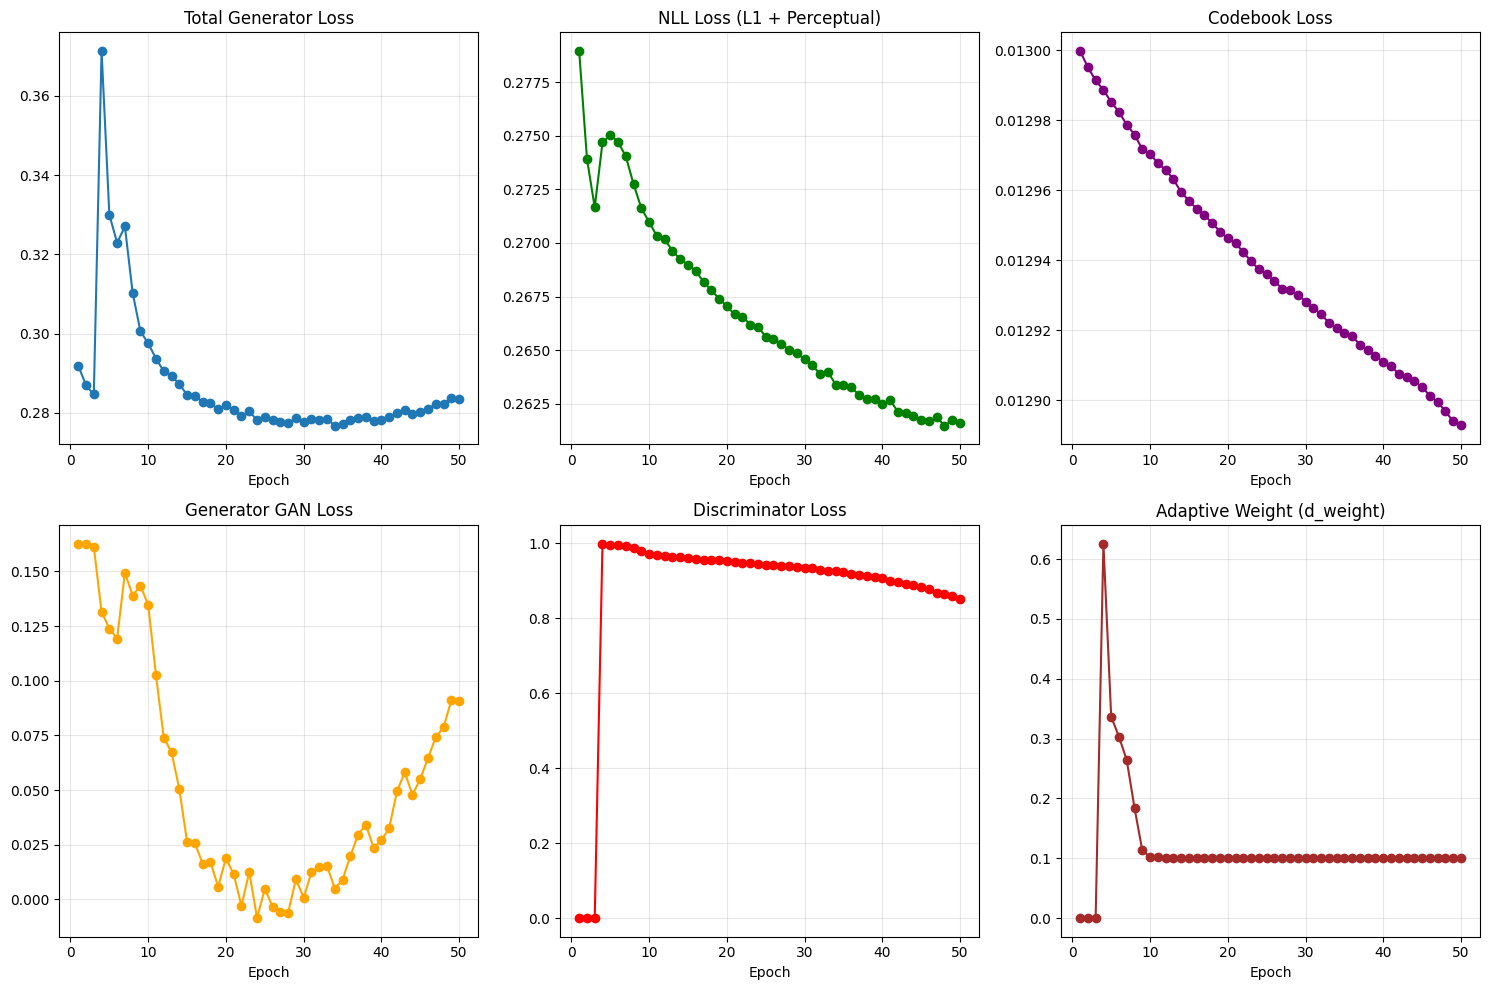

✅ 학습 곡선 저장됨: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/training_curves.png


In [29]:
# =============================================================================
# 학습 곡선 시각화 (여러 Loss 항목)
# =============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# train_logs는 딕셔너리 리스트이므로 각 항목 추출
epochs = range(1, len(train_logs) + 1)

# Total Loss
axes[0, 0].plot(epochs, [log['total_loss'] for log in train_logs], marker='o')
axes[0, 0].set_title('Total Generator Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].grid(True, alpha=0.3)

# NLL Loss (L1 + Perceptual)
axes[0, 1].plot(epochs, [log['nll_loss'] for log in train_logs], marker='o', color='green')
axes[0, 1].set_title('NLL Loss (L1 + Perceptual)')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].grid(True, alpha=0.3)

# Codebook Loss
axes[0, 2].plot(epochs, [log['codebook_loss'] for log in train_logs], marker='o', color='purple')
axes[0, 2].set_title('Codebook Loss')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].grid(True, alpha=0.3)

# G Loss
axes[1, 0].plot(epochs, [log['g_loss'] for log in train_logs], marker='o', color='orange')
axes[1, 0].set_title('Generator GAN Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].grid(True, alpha=0.3)

# D Loss
axes[1, 1].plot(epochs, [log['d_loss'] for log in train_logs], marker='o', color='red')
axes[1, 1].set_title('Discriminator Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].grid(True, alpha=0.3)

# Adaptive Weight
axes[1, 2].plot(epochs, [log['d_weight'] for log in train_logs], marker='o', color='brown')
axes[1, 2].set_title('Adaptive Weight (d_weight)')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
save_path = f"{save_dir}/training_curves.png"
plt.savefig(save_path, dpi=150)
plt.show()
print(f"✅ 학습 곡선 저장됨: {save_path}")

/tmp/ipython-input-958975534.py:64: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-958975534.py:64: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-958975534.py:66: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=150)
/tmp/ipython-input-958975534.py:66: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=150)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


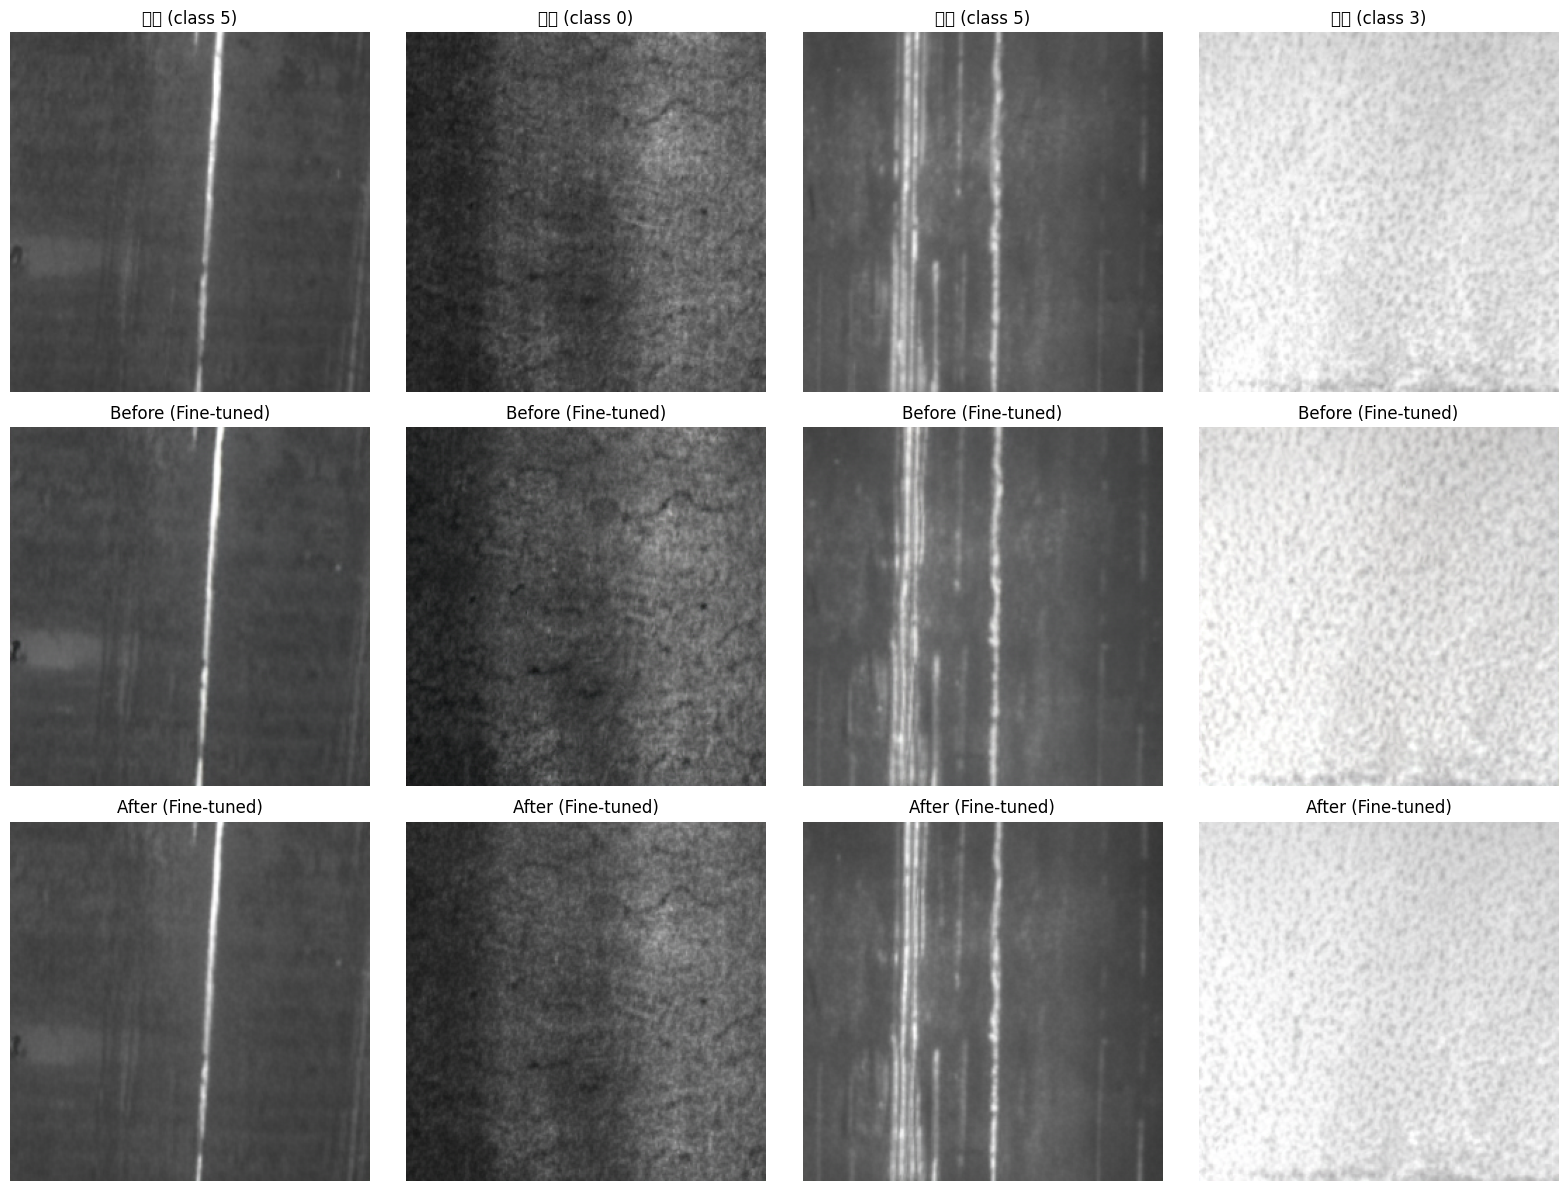

✅ 비교 이미지 저장됨: /content/drive/MyDrive/metal-defect/LlamaGen/checkpoints/comparison_before_after.png


In [32]:
# =============================================================================
# Fine-tuning 전후 비교
# =============================================================================

# denormalize 함수
def denormalize(tensor):
    """[-1, 1] 범위를 [0, 1]로 변환"""
    img = tensor.cpu().detach()
    img = (img + 1) / 2
    img = img.clamp(0, 1)
    img = img.permute(1, 2, 0).numpy()
    return img

# Fine-tuned 모델을 평가 모드로
model.eval()

# 테스트 배치 가져오기
test_images, test_labels = next(iter(dataloader))
test_images = test_images.to(device)

# LlamaGen VQGAN 생성
original_model = VQ_models["VQ-16"](
    codebook_size=16384,
    codebook_embed_dim=8,      # 핵심! taming은 256
    commit_loss_beta=0.25,
)

# pretrained 로드
ckpt = torch.load("/content/LlamaGen/pretrained_models/vq_ds16_c2i.pt", map_location="cpu")
if "model" in ckpt:
    original_model.load_state_dict(ckpt["model"])
elif "ema" in ckpt:
    original_model.load_state_dict(ckpt["ema"])
else:
    original_model.load_state_dict(ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_model = original_model.to(device)

# 재구성
with torch.no_grad():

    # Original 모델
    rec, _ = original_model(test_images)
    # Fine-tuned 모델
    rec_finetuned, _ = model(test_images)

# 시각화
n_samples = min(4, test_images.size(0))
fig, axes = plt.subplots(3, n_samples, figsize=(4*n_samples, 12))

for i in range(n_samples):
    axes[0, i].imshow(denormalize(test_images[i]))
    axes[0, i].set_title(f"원본 (class {test_labels[i].item()})")
    axes[0, i].axis('off')

    axes[1, i].imshow(denormalize(rec[i]))
    axes[1, i].set_title(f"Before (Fine-tuned)")
    axes[1, i].axis('off')

    axes[2, i].imshow(denormalize(rec_finetuned[i]))
    axes[2, i].set_title("After (Fine-tuned)")
    axes[2, i].axis('off')

plt.tight_layout()
save_path = f"{save_dir}/comparison_before_after.png"
plt.savefig(save_path, dpi=150)
plt.show()
print(f"✅ 비교 이미지 저장됨: {save_path}")

In [33]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2

# LlamaGen VQGAN 생성
model_original = VQ_models["VQ-16"](
    codebook_size=16384,
    codebook_embed_dim=8,      # 핵심! taming은 256
    commit_loss_beta=0.25,
)

# pretrained 로드
ckpt = torch.load("/content/LlamaGen/pretrained_models/vq_ds16_c2i.pt", map_location="cpu")
if "model" in ckpt:
    model_original.load_state_dict(ckpt["model"])
elif "ema" in ckpt:
    model_original.load_state_dict(ckpt["ema"])
else:
    model_original.load_state_dict(ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_original = model_original.to(device)

with torch.no_grad():
    rec_orig, _ = model_original(test_images)
    rec_ft, _ = model(test_images)

    # 텐서 -> numpy (B, C, H, W) -> (B, H, W, C)
    orig_np = test_images.cpu().permute(0, 2, 3, 1).numpy()
    rec_orig_np = rec_orig.cpu().permute(0, 2, 3, 1).numpy()
    rec_ft_np = rec_ft.cpu().permute(0, 2, 3, 1).numpy()

    # 배치 평균 계산
    psnr_before, psnr_after = [], []
    ssim_before, ssim_after = [], []
    edge_before, edge_after = [], []

    for i in range(len(orig_np)):
        # 0-1 범위로 클리핑
        orig_img = np.clip(orig_np[i], 0, 1)
        rec_o = np.clip(rec_orig_np[i], 0, 1)
        rec_f = np.clip(rec_ft_np[i], 0, 1)

        # PSNR
        psnr_before.append(psnr(orig_img, rec_o, data_range=1.0))
        psnr_after.append(psnr(orig_img, rec_f, data_range=1.0))

        # SSIM (multichannel)
        ssim_before.append(ssim(orig_img, rec_o, data_range=1.0, channel_axis=2))
        ssim_after.append(ssim(orig_img, rec_f, data_range=1.0, channel_axis=2))

        # Edge preservation (grayscale로 변환 후 Canny)
        orig_gray = (orig_img.mean(axis=2) * 255).astype(np.uint8)
        rec_o_gray = (rec_o.mean(axis=2) * 255).astype(np.uint8)
        rec_f_gray = (rec_f.mean(axis=2) * 255).astype(np.uint8)

        edges_orig = cv2.Canny(orig_gray, 50, 150)
        edges_rec_o = cv2.Canny(rec_o_gray, 50, 150)
        edges_rec_f = cv2.Canny(rec_f_gray, 50, 150)

        # 엣지 IoU (intersection over union)
        iou_before = (edges_orig & edges_rec_o).sum() / ((edges_orig | edges_rec_o).sum() + 1e-6)
        iou_after = (edges_orig & edges_rec_f).sum() / ((edges_orig | edges_rec_f).sum() + 1e-6)
        edge_before.append(iou_before)
        edge_after.append(iou_after)

print(f"PSNR  - Before: {np.mean(psnr_before):.2f}dB, After: {np.mean(psnr_after):.2f}dB")
print(f"SSIM  - Before: {np.mean(ssim_before):.4f}, After: {np.mean(ssim_after):.4f}")
print(f"Edge IoU - Before: {np.mean(edge_before):.4f}, After: {np.mean(edge_after):.4f}")

PSNR  - Before: infdB, After: infdB
SSIM  - Before: 0.7297, After: 0.7350
Edge IoU - Before: 0.2027, After: 0.2242


/usr/local/lib/python3.12/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)
